# 소개하세요
안녕하세요! 이 다소 빠르고 더러운 커널은 케라스의 신경망을 사용하여 핵을 분할하는 방법을 보여줍니다. 

사용된 아키텍처는 소위 [U-Net](https://arxiv.org/abs/1505.04597),)로, 이와 같은 이미지 분할 문제에 매우 일반적입니다. 작은 데이터 세트에서도 잘 작동하는 경향이 있다고 생각합니다.

우리가 필요한 모든 것을 수입하기 시작해요!

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain # chain('ABC', 'DEF') --> A B C D E F
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label # 정수 배열의 연결된 영역에 레이블을 지정하십시오.


from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
len(train_ids)

670

In [4]:
train_ids

['00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552',
 '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1',
 '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e',
 '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed',
 '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf',
 '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21',
 '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426',
 '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339',
 '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776',
 '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe',
 '03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a',
 '0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd',
 '04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e',
 '05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13',
 '0532c64c2fd0c4d3188cc751cdfd566b

# 데이터를 가져옵니다.
먼저 모든 이미지와 관련 마스크를 가져오겠습니다. 저는 상황을 가볍고 관리하기 쉽게 하기 위해 훈련 이미지와 테스트 이미지를 모두 샘플링하지만, 예측된 마스크를 샘플링하고 나중에 올바른 실행 길이 인코딩을 만들기 위해 테스트 이미지의 원래 크기를 기록해야 합니다. 확실히 이것을 다루는 더 좋은 방법들이 있지만, 지금은 잘 작동해요!


In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)# 이미지
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)#마스크
print('Getting and resizing train images and masks ... ')

sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_ # './input/stage1_train/077f026f4ab0f0bcc0856644d99cbf639e443ec4f067d7b708bc6cecac609424'
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS] # rgb제거? 4열->3열
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) # (256, 256, 3) ->(128, 128, 3)
    X_train[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]: # './input/stage1_train/077f026f4ab0f0bcc0856644d99cbf639e443ec4f067d7b708bc6cecac609424/masks/'
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1) # (IMG_HEIGHT, IMG_WIDTH, 1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask # boolean 형태

Y_train = Y_train.astype(int) # boolean->숫자

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')

sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


C:\Users\HOME\AppData\Local\Temp/ipykernel_13024/4237281109.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)#마스크
  0%|                                                                                          | 0/670 [00:00<?, ?it/s]C:\Users\HOME\AppData\Local\Temp/ipykernel_13024/4237281109.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and g

Getting and resizing test images ... 



100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 39.50it/s]

Done!


랜덤 이미지와 관련된 마스크를 그려서 문제가 없는지 살펴봅니다.


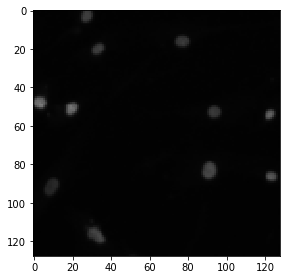

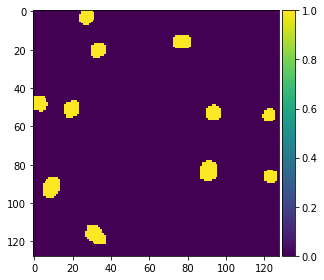

In [4]:
# 훈련 데이터가 정상인지 확인합니다.
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

그거 좋군요.

# Keras 메트릭을 만듭니다.

이제 우리는 Keras에서 다른 교차로에서의 평균 정밀도(IoU)* 메트릭을 정의하려고 합니다. TensorFlow에는 평균 IOU 메트릭이 있지만 여러 임계값에 대한 평균에 대한 네이티브 지원이 없기 때문에 이를 구현하려고 했습니다. **하지만 이 구현이 정확한지 확신할 수 없습니다!** 이를 검증하는 데 도움이 된다면 매우 환영할 것입니다!

*업데이트: 이 구현은 여기에서 보고된 결과와 LB 결과 사이에 매우 큰 차이가 있기 때문에 분명 정확하지 않습니다. 또한 훈련할 때 시간이 지남에 따라 증가하는 것처럼 보입니다. *


In [8]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.compat.v1.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.compat.v1.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
def mean_iou_accuracy_op(y_pred, y_true, x):
    with tf.name_scope('Accuracy'):
        prec = []
        for t in np.arange(0.5, 1.0, 0.05):
            y_pred_tmp = tf.to_int32(y_pred > 0.5)
            score, update_op = tf.metrics.mean_iou(y_true, y_pred_tmp, 2)
            with tf.Session() as sess:
                sess.run(tf.local_variables_initializer())
            with tf.control_dependencies([update_op]):
                score = tf.identity(score)
            prec.append(score)
        acc = tf.reduce_mean(tf.stack(prec), axis=0, name='mean_iou')
    return acc

# 우리의 신경망을 구축하고 훈련시킵니다.
다음으로 [U-Net: 생물의학 이미지 분할을 위한 컨볼루션 네트워크](https://arxiv.org/pdf/1505.04597.pdf))를 대략 기반으로 하고 캐글 초음파 신경 분할 경쟁의 [이 레포](https://github.com/jocicmarko/ultrasound-nerve-segmentation))와 매우 유사한 U-Net 모델을 구축합니다.
![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [17]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_4 (Lambda)              (None, 128, 128, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 128, 128, 16  448         ['lambda_4[0][0]']               
                                )                                                                 
                                                                                            

*업데이트: ELU 유닛으로 변경되어 중퇴자가 추가되었습니다.*

그런 다음 검증 분할 0.1을 사용하여 교육 데이터에 모형을 적합시킵니다. 우리는 데이터가 너무 적기 때문에 작은 배치 크기를 사용합니다. 모델을 교육할 때 체크포인트 및 조기 정지를 사용하는 것이 좋습니다. 여기서는 재현성을 높이기 위해 이 작업을 수행하지 않습니다(어쨌든 결과가 다를 가능성이 매우 높지만). 현재 파라미터로 10분 정도 캐글 커널에서 10분 정도 걸리는 에폭스를 훈련해 보겠습니다. 

*업데이트: 조기 정지 및 체크포인트가 추가되어 30에폭으로 늘어났습니다.*

In [51]:
X_train.shape

(670, 128, 128, 3)

In [52]:
Y_train.shape

(670, 128, 128, 1)

In [19]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 0.4288 - mean_io_u: 0.3988
Epoch 1: val_loss improved from inf to 0.23593, saving model to model-dsbowl2018-1.h5
38/38 [==============================] - 116s 3s/step - loss: 0.4288 - mean_io_u: 0.3988 - val_loss: 0.2359 - val_mean_io_u: 0.4081
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.2133 - mean_io_u: 0.3988
Epoch 2: val_loss improved from 0.23593 to 0.15329, saving model to model-dsbowl2018-1.h5
38/38 [==============================] - 106s 3s/step - loss: 0.2133 - mean_io_u: 0.3988 - val_loss: 0.1533 - val_mean_io_u: 0.4081
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.1491 - mean_io_u: 0.3988
Epoch 3: val_loss improved from 0.15329 to 0.12909, saving model to model-dsbowl2018-1.h5
38/38 [==============================] - 131s 3s/step - loss: 0.1491 - mean_io_u: 0.3988 - val_loss: 0.1291 - val_mean_io_u: 0.4081
Epoch 4/50
38/38 [==============================] - E

좋아요, 좋아 보이네요! 하지만 손실은 약간 불규칙한 것 같습니다. 모델 구조와 매개변수의 개선은 당신에게 맡기겠습니다! 

# 예측을 합니다.

테스트 세트, 밸브 세트 및 열차 세트에 대해 모두 예측합니다(건전성 검사로). 조기 중지 및 체크포인트를 사용한 경우 가장 잘 저장된 모델을 로드해야 합니다.

In [20]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

3/3 [==============================] - 1s 346ms/step


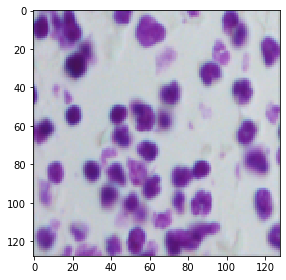

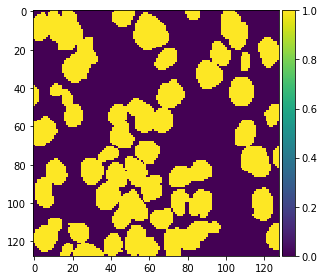

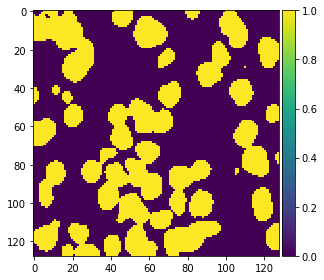

In [21]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

모형은 최소한 교육 데이터에 적합할 수 있습니다! 여기에서도 확실히 개선의 여지가 많지만, 좋은 시작입니다. 검증 자료는 어떻습니까?


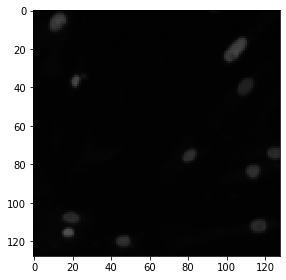

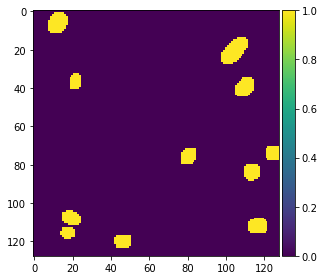

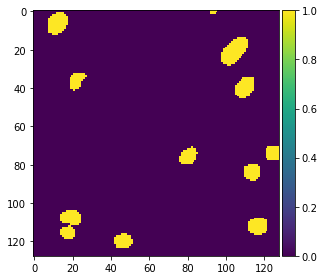

In [22]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

너무 초라하지 마세요! 확실히 더 많은 훈련과 조정이 필요합니다.

# 결과를 인코딩하고 제출합니다.

이제 결과를 제출할 차례입니다. [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python))를 훔쳤습니다. 실행 길이 인코딩의 훌륭한 구현입니다.

In [23]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

테스트 ID를 반복하고 skimage로 식별된 각 개별 마스크에 대해 실행 길이 인코딩을 생성해 보겠습니다.


In [24]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [25]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

이것은 LB에서 0.233점을 받았습니다. 이 노트북의 버전 2에서는 신경망의 결과가 매우 불규칙하고 실행마다 크게 다릅니다(예: 버전 3은 훨씬 더 나쁩니다). 버전 7은 0.277입니다!

몇 가지 매개 변수를 변경하고, 아키텍처를 약간 조정하고, 조기 정지를 통해 더 오래 교육하는 것만으로도 쉽게 결과를 안정시키고 개선할 수 있습니다.

재미있는 시간 보내세요.**

LB 점수 기록입니다.
- 버전 7: 0.277LB입니다.